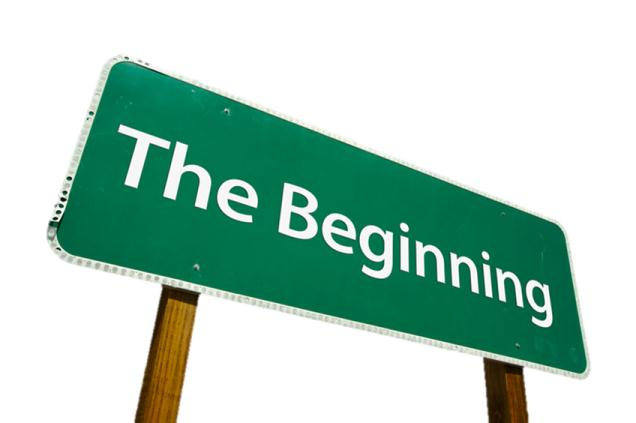

# Introduction

Welcome to our first try

# Importing important libraries

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import numpy as np
import pandas as pd
import gc
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
import joblib

In [ ]:
# display all the columns in the dataset
pd.pandas.set_option('display.max_columns', None)

# Get the Data

In [ ]:
# Load the Data
train= pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv')
calendar = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')
sell_prices = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv')
sample = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sample_submission.csv")


# Inspect the data

In [ ]:
print("train:",train.shape,",","calendar:",calendar.shape,",","sell_prices:",sell_prices.shape)

In [ ]:
train.info()

In [ ]:
calendar.info()

In [ ]:
train.head()

In [ ]:
calendar.head()

In [ ]:
sell_prices.head()

#  **Check for Null**

In [ ]:
train.isnull().sum().sort_values(ascending = False)

In [ ]:
calendar.isnull().sum().sort_values(ascending = False)

# Add Zero sales for dates d_1942 to d_1969

In [ ]:
for i in range(1942,1970):
    col = "d_"+ str(i)
    train[col] = 0

In [ ]:
train.head()

# Memory usage control

In [ ]:
#Downcasting
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

train = downcast(train)
sell_prices = downcast(sell_prices)
calendar = downcast(calendar)

In [ ]:
train_ad = np.round(train.memory_usage().sum()/(1024*1024),1)
calendar_ad = np.round(calendar.memory_usage().sum()/(1024*1024),1)
sell_prices_ad = np.round(sell_prices.memory_usage().sum()/(1024*1024),1)

# Melt data to create single dataset

<img src="https://33.media.tumblr.com/f6d253eff4ed0701713e4f4df06bead4/tumblr_nhpzm2MsRf1qzeylbo1_r1_500.gif">

We start by converting the train dataframe from wide to long format.

In [ ]:
#melt data
melt_df = pd.melt(train, 
                  id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                  var_name = 'd', 
                  value_name = "sales").dropna()

In [ ]:
melt_df.head()


In [ ]:
single= pd.merge(melt_df,calendar, on='d', how = "left")
single.head()

In [ ]:
del calendar,melt_df
gc.collect()

In [ ]:
single = pd.merge(single, sell_prices, on=['store_id','item_id','wm_yr_wk'], how='left') 
single.head(20)

In [ ]:
del sell_prices
gc.collect()

In [ ]:
print(single.shape)
single2= single[single['cat_id']== 'HOBBIES']
print(single2.info())
print(single2.shape)

# EDA

In [ ]:
#Sales by Store
states = pd.DataFrame(single2.state_id.unique(),columns=['state_id'])
bar_data = single2.groupby(['state_id', 'store_id'])['sales'].sum().dropna()
bar_data
plt.ticklabel_format(style = 'plain')
plt.ylabel("State/Store")
plt.xlabel("Number of sales")
plt.title("Sales by Store")

bar_data.plot(kind='barh',figsize=(18, 10))




In [ ]:
#Revenue by State
single2['revenue'] = single2['sales']*single2['sell_price'].astype(np.float32)
bar_data2 = single2.groupby(['state_id'])['revenue'].sum().dropna()
bar_data2
plt.ticklabel_format(style = 'plain')
plt.ylabel("State")
plt.xlabel("Revenue")
plt.title("Revenue by State")
bar_data2.plot(kind='barh',figsize=(10, 7))

In [ ]:
#Revenue by Store
bar_data3=single2.groupby(['store_id'])['revenue'].sum().dropna()
plt.ticklabel_format(style = 'plain')
plt.ylabel("Store")
plt.xlabel("Revenue")
plt.title("Revenue by Store")
bar_data3.plot(kind='barh',figsize=(10,8))

**Prices for Hobbies 1 items by store of each state**

In [ ]:
group_price_store = single2.groupby(['state_id','store_id','item_id'],as_index=False)['sell_price'].mean().dropna()
fig = px.violin(group_price_store, x='store_id', color='state_id', y='sell_price',box=True, hover_name='item_id')
fig.update_xaxes(title_text='Store')
fig.update_yaxes(title_text='Selling Price($)')
fig.update_layout(template='seaborn',title='Distribution of Item prices across Stores',legend_title_text='State')
fig.show()                                                                                        

**Let's take a look in sales by month-year**

In [ ]:
data = single2.groupby(['store_id', pd.Grouper(key='date', freq='M')])['sales'].sum()
data = data[data>0]
fig = px.line(
    data_frame=data.reset_index(),
    x = 'date',
    y = 'sales',
    color = 'store_id'
    
)
fig.update_xaxes(nticks=7)
fig.update_layout(
    title = dict(text = 'units sold by month-year')
)
fig.show()

In [ ]:
#Average Weekly sales by day
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
single2["weekday"] = pd.Categorical(single2.weekday, categories=days, ordered=True)
data = single2.loc[single2.sales>0].groupby(['weekday','store_id',])['sales'].mean().reset_index()
fig = px.line(              
    data_frame=data,
    x = 'weekday',
    y = 'sales',
    color = 'store_id'
    
)
fig.update_layout(
    title = dict(text='Average units sold by store')
)

fig.show()

In [ ]:
data2 = single2.sort_values('revenue',ascending=False).groupby(['year']).nth(1)
data2
data3 = data2.reset_index()

fig = px.bar(
    data_frame=data3,
    x = 'year',
    y = 'revenue',
    color = 'store_id'
    
)
fig.update_layout(
    title = dict(text='Store with highest Revenues by year')
)

fig.show()


In [ ]:
data3 = single2.sort_values('sales',ascending=False).groupby(['year']).nth(1)
data2
data4 = data3.reset_index()

fig = px.bar(
    data_frame=data4,
    x = 'year',
    y = 'sales',
    color = 'store_id'
    
)
fig.update_layout(
    title = dict(text='Store with most sales by year')
)

fig.show()

# Model Building - LGBM - Feature Engineering

In [ ]:
# convert numeric variables into categorical variables
conv_id = dict(zip(single2.id.cat.codes, single2.id))
conv_item_id = dict(zip(single2.item_id.cat.codes, single2.item_id))
conv_dept_id = dict(zip(single2.dept_id.cat.codes, single2.dept_id))
conv_cat_id = dict(zip(single2.cat_id.cat.codes, single2.cat_id))
conv_store_id = dict(zip(single2.store_id.cat.codes, single2.store_id))


In [ ]:
single2.d = single2['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)
cols = single2.dtypes.index.tolist()
types = single2.dtypes.values.tolist()
for i,type in enumerate(types):
    if type.name == 'category':
        single2[cols[i]] = single2[cols[i]].cat.codes

In [ ]:
single2.head()

In [ ]:
single2.drop('date',1,inplace = True)

# Introduce Lags

In [ ]:
#Introduce lags
lags = [1,2,3,6,12,24,36]
for lag in lags:
    single2['sold_lag_'+str(lag)] = single2.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['sales'].shift(lag).astype(np.float16)

# Rolling Window Statistics

In [ ]:
single2['rolling_sold_mean'] = single2.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sales'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)

# Trends

In [ ]:
single2['daily_avg_sold'] = single2.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d'])['sales'].transform('mean').astype(np.float16)
single2['avg_sold'] = single2.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sales'].transform('mean').astype(np.float16)
single2['selling_trend'] = (single2['daily_avg_sold'] - single2['avg_sold']).astype(np.float16)
single2.drop(['daily_avg_sold','avg_sold'],axis=1,inplace=True)

In [ ]:
single2.info()

# Create Train,Validity and Test Dataframes

In [ ]:
valid = single2[(single2['d']>=1914) & (single2['d']<1942)][['id','d','sales']]
test = single2[single2['d']>=1942][['id','d','sales']]
eval_preds = test['sales']
valid_preds = valid['sales']

In [ ]:
single2 = single2[single2['d']>=36]

In [ ]:
single2.to_pickle('data.pkl')
del single2
gc.collect();

In [ ]:
data = pd.read_pickle('data.pkl')
valid = data[(data['d']>=1914) & (data['d']<1942)][['id','d','sales']]
test = data[data['d']>=1942][['id','d','sales']]
eval_preds = test['sales']
valid_preds = valid['sales']

In [ ]:
#Get the store ids
stores = train.store_id.cat.codes.unique().tolist()
for store in stores:
    df = data[data['store_id']==store]
    
    #Split the data
    X_train, y_train = df[df['d']<1914].drop('sales',axis=1), df[df['d']<1914]['sales']
    X_valid, y_valid = df[(df['d']>=1914) & (df['d']<1942)].drop('sales',axis=1), df[(df['d']>=1914) & (df['d']<1942)]['sales']
    X_test = df[df['d']>=1942].drop('sales',axis=1)
    
    #Train and validate
    model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=8,
        num_leaves=50,
        min_child_weight=300
    )
    print('*****Prediction for Store: {}*****'.format(conv_store_id[store]))
    model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
             eval_metric='rmse', verbose=20, early_stopping_rounds=20)
    valid_preds[X_valid.index] = model.predict(X_valid)
    eval_preds[X_test.index] = model.predict(X_test)
    filename = 'model'+str(conv_store_id[store])+'.pkl'
    # save model
    joblib.dump(model, filename)
    
    del model, X_train, y_train, X_valid, y_valid
    gc.collect()

In [ ]:
#Feature importance
feature_importance_df = pd.DataFrame()
features = [f for f in data.columns if f != 'sales']
for filename in os.listdir('/kaggle/working/'):
    if 'model' in filename:
        # load model
        model = joblib.load(filename)
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (averaged over store predictions)')
    plt.tight_layout()
    
display_importances(feature_importance_df)

# Make submission


In [ ]:
valid['sales'] = valid_preds
validation = valid[['id','d','sales']]
validation = pd.pivot(validation, index='id', columns='d', values='sales').reset_index()
validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
validation.id = validation.id.map(conv_id).str.replace('evaluation','validation')

  
  #Get the evaluation results
test['sales'] = eval_preds
evaluation = test[['id','d','sales']]
evaluation = pd.pivot(evaluation, index='id', columns='d', values='sales').reset_index()
evaluation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
#Remap the category id to their respective categories
evaluation.id = evaluation.id.map(conv_id)

#Prepare the submission
submit = pd.concat([validation,evaluation]).reset_index(drop=True)
submit.to_csv('submission1.csv',index=False)